In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.feature_selection import mutual_info_classif
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
# Load and preprocess data

df = pd.read_csv("Churn_Modelling.csv")
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})
df = pd.get_dummies(df, columns=['Geography'], drop_first=True)

X = df.drop("Exited", axis=1)
y = df["Exited"]

In [12]:
# Feature selection using Mutual Information

mi_scores = mutual_info_classif(X, y, discrete_features='auto', random_state=42)
mi_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)
top_features = mi_series.head(8).index.tolist()
X_selected = X[top_features]

In [13]:
# Feature scaling

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

In [14]:
# Train-test split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

In [15]:
# Define models with hyperparameter tuning

param_grid_rf = {
    'n_estimators': [100, 120, 150],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'random_state': [42]
}

param_grid_gb = {
    'n_estimators': [100, 120, 150],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'random_state': [42]
}

In [16]:
# Use GridSearchCV to tune RandomForest and GradientBoosting

rf_grid_search = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=3, scoring='roc_auc', verbose=1)
gb_grid_search = GridSearchCV(GradientBoostingClassifier(), param_grid_gb, cv=3, scoring='roc_auc', verbose=1)

In [17]:
# Train models with the best hyperparameters

rf_grid_search.fit(X_train, y_train)
gb_grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Fitting 3 folds for each of 27 candidates, totalling 81 fits


GridSearchCV(cv=3, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 120, 150],
                         'random_state': [42]},
             scoring='roc_auc', verbose=1)

In [18]:
# Get the best models

best_rf = rf_grid_search.best_estimator_
best_gb = gb_grid_search.best_estimator_

In [19]:
# Logistic Regression model

log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [20]:
# Evaluate models

models = {
    "Logistic Regression": log_reg,
    "Random Forest": best_rf,
    "Gradient Boosting": best_gb
}


--- Logistic Regression ---
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      1593
           1       0.61      0.20      0.30       407

    accuracy                           0.81      2000
   macro avg       0.72      0.58      0.59      2000
weighted avg       0.78      0.81      0.77      2000

Confusion Matrix:
[[1541   52]
 [ 327   80]]
ROC AUC Score: 0.7767968276442853


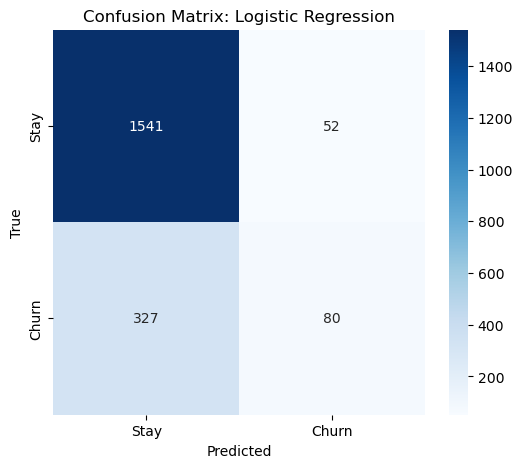


--- Random Forest ---
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1593
           1       0.80      0.45      0.58       407

    accuracy                           0.87      2000
   macro avg       0.84      0.71      0.75      2000
weighted avg       0.86      0.87      0.85      2000

Confusion Matrix:
[[1548   45]
 [ 224  183]]
ROC AUC Score: 0.8691495810139879


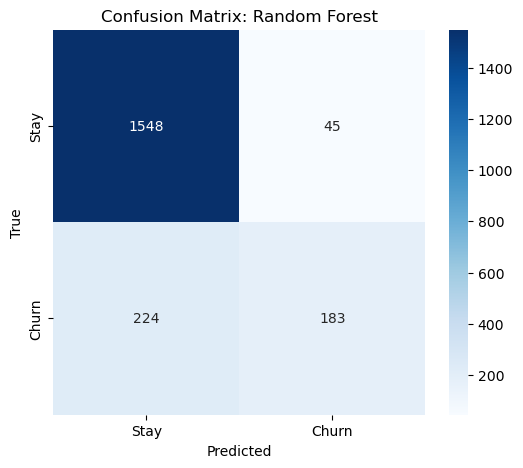


--- Gradient Boosting ---
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1593
           1       0.79      0.47      0.59       407

    accuracy                           0.87      2000
   macro avg       0.83      0.72      0.76      2000
weighted avg       0.86      0.87      0.85      2000

Confusion Matrix:
[[1541   52]
 [ 214  193]]
ROC AUC Score: 0.8701852854395227


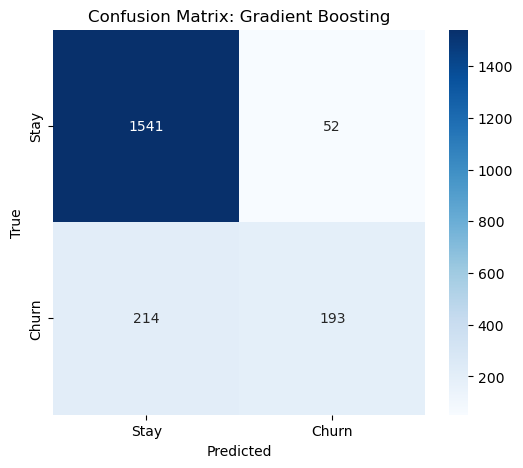

In [21]:
# Evaluate and plot confusion matrix for each model

for name, model in models.items():
    print(f"\n--- {name} ---")
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

    # Plot Confusion Matrix as heatmap
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Stay", "Churn"], yticklabels=["Stay", "Churn"])
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [22]:
# USER INTERACTIVE PREDICTION SECTION

def predict_churn_interactive(model, scaler, top_features, all_features):
    print("\n--- Customer Churn Prediction ---")
    
    credit_score = int(input("Credit Score (e.g. 600): "))
    geography = input("Geography (France/Germany/Spain): ")
    gender = input("Gender (Male/Female): ")
    age = int(input("Age (e.g. 42): "))
    tenure = int(input("Tenure (Years with bank): "))
    balance = float(input("Account Balance (e.g. 125000): "))
    num_products = int(input("Number of Products (1-4): "))
    has_card = int(input("Has Credit Card (1=Yes, 0=No): "))
    is_active = int(input("Is Active Member (1=Yes, 0=No): "))
    salary = float(input("Estimated Salary (e.g. 50000): "))

    new_customer = pd.DataFrame([{
        'CreditScore': credit_score,
        'Geography': geography,
        'Gender': gender,
        'Age': age,
        'Tenure': tenure,
        'Balance': balance,
        'NumOfProducts': num_products,
        'HasCrCard': has_card,
        'IsActiveMember': is_active,
        'EstimatedSalary': salary
    }])

    new_customer['Gender'] = new_customer['Gender'].map({'Male': 0, 'Female': 1})
    new_customer = pd.get_dummies(new_customer, columns=['Geography'], drop_first=True)

    for col in all_features:
        if col not in new_customer.columns:
            new_customer[col] = 0
    new_customer = new_customer[all_features]

    new_customer_selected = new_customer[top_features]
    new_customer_scaled = scaler.transform(new_customer_selected)

    prediction = model.predict(new_customer_scaled)
    probability = model.predict_proba(new_customer_scaled)[0, 1]

    print("\nPrediction Result:")
    print("Customer is likely to CHURN" if prediction[0] == 1 else "Customer will STAY")
    print(f"Churn Probability: {probability:.2f}")

# Run the prediction interaction using the best model
predict_churn_interactive(best_rf, scaler, top_features, X.columns.tolist())


--- Customer Churn Prediction ---


Credit Score (e.g. 600):  635
Geography (France/Germany/Spain):  Germany
Gender (Male/Female):  Female
Age (e.g. 42):  45
Tenure (Years with bank):  3
Account Balance (e.g. 125000):  95000
Number of Products (1-4):  2
Has Credit Card (1=Yes, 0=No):  1
Is Active Member (1=Yes, 0=No):  0
Estimated Salary (e.g. 50000):  64000



Prediction Result:
Customer will STAY
Churn Probability: 0.33
